In [6]:
import joblib
from pathlib import Path
import pandas as pd
import numpy as np
import itertools

from matplotlib import pyplot as plt
import matplotlib.dates as mdatesDateFormatter
import seaborn as sns

import lightgbm as lgb
import xgboost as xgb

from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import IsolationForest

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# from yellowbrick.regressor import PredictionError
# https://colab.research.google.com/drive/1bA_TrrmRpgJ0jasWBZCxkXSLePi8uWBx#scrollTo=vuGPBr97l7qN
# https://www.youtube.com/watch?v=ZUK4zR0IeLU
# 


In [7]:
# jupter notebook settings

dark_orange = "#FF8C00"
dark_blue = "#00008B"
dark_green = "#006400"
dark_cyan = "#008B8B"
dark_slate = "#2F4F4F"
dark_magenta = "#8B008B"
dark_red = "#8B0000"
dark_olive = "#556B2F"
crimson = "#DC143C"

yellow_green = "#9ACD32"
lime_green = "#32CD32"
lime = "#00FF00"
gold = "#FFD700"
golden_rod = "#DAA520"
dark_golden_rod = "#B8860B"
light_blue = "#AED6F1"
light_red = "#F1948A"
highlight_green = "green"
highlight_red = "red"

color_train = dark_cyan
color_test = "#1f77b4"
color_future = "#ff7f0e"
color_forecast = "#ff7f0e"
color_predict = yellow_green


In [94]:
# funcoes auxiliares


def create_features(df):
    """Adiciona a hora da coleta no formato decimal (por exemplo, 16.25 representa 16:15))"""

    df["hour_min"] = df.index.hour + (df.index.minute / 60)
    return df

# MAPE
def mean_absolute_percentage_error(y_true, xgb_pred):
    y_true, xgb_pred = np.array(y_true), np.array(xgb_pred)
    return (np.mean(np.abs((y_true[y_true != 0] - xgb_pred[y_true != 0]) / y_true[y_true != 0])) * 100)


# sMAPE
def symmetric_mean_absolute_percentage_error(y_true, xgb_pred):
    return 200 * np.mean(np.abs(xgb_pred - y_true) / (np.abs(xgb_pred) + np.abs(y_true)))


# RMSE
def root_mean_squared_error(y_true, xgb_pred):
    return np.sqrt(mean_squared_error(y_true, xgb_pred))


def print_forecast_accuracy(y_true, xgb_pred, title):
    acc = calculate_forecast_accuracy(y_true, xgb_pred)

    print("\n" + "=" * 120)
    print(f"Resumo das métricas de precisão (forecast accuracy - {title})".center(120))
    print("=" * 120 + "\n")
    print(f"MAE  : {acc['mae']:>8.2f} - As previsões, em média, estão {acc['mae']:0.2f} unidades distantes dos valores reais.")
    print(f"RMSE : {acc['rmse']:>8.2f} - O erro médio do seu modelo é de {acc['rmse']:0.2f} unidades em relação aos valores observados.")
    print(f"R²   : {acc['r2']:>8.2f} - O coeficiente de determinação R² é {acc['r2']:0.2f}.")
    print(f"MSE  : {acc['mse']:>8.2f} - A média dos quadrados das diferenças entre os valores previstos e reais é {acc['mse']:0.2f}")
    print(f"MAPE : {acc['mape']:>7.2f}% - As previsões, em média, estão desviando em {acc['mape']:0.2f}% dos valores reais.")
    print(f"sMAPE: {acc['smape']:>7.2f}% - indica um desvio médio de {acc['smape']:0.2f}% das previsões em relação aos valores reais.")
    print("=" * 120 + "\n")


def calculate_forecast_accuracy(y_true, xgb_pred):
    return {
        "mae": mean_absolute_error(y_true, xgb_pred),
        "rmse": root_mean_squared_error(y_true, xgb_pred),
        "mse": mean_squared_error(y_true, xgb_pred),
        "r2": r2_score(y_true, xgb_pred),
        "mape": mean_absolute_percentage_error(y_true, xgb_pred),
        "smape": symmetric_mean_absolute_percentage_error(y_true, xgb_pred),
    }


def get_tuning_hyperparameter(model, params, X_train, y_train, cv=5):
    score = "neg_root_mean_squared_error"

    grid_search = RandomizedSearchCV(
        model,
        params,
        scoring=score,
        n_iter=20,
    )

    grid_search.fit(X_train, y_train)

    return grid_search


def plot_forecast(df, model, start=None, end=None, span=False):
    df_plot = df[start:end] if start and end else df.copy()
    plt.figure(figsize=(22, 5))

    colors = sns.color_palette("deep")

    for col in df_plot.columns:
        params = {
            "train": {"label": "Train set", "color": color_train, "lw": 2, "ls": "-"},
            "test": {"label": "Test set", "color": color_test, "lw": 2, "ls": "-"},
            "xgb_pred": {"label": "Predict (XGBoost)", "color": color_forecast, "lw": 2, "ls": "-"},
            "lgb_pred": {"label": "Predict (LightGBM)", "color": colors[2], "lw": 2, "ls": "-"},
            "lr_pred": {"label": "Predict (Linear Reg)", "color": colors[2], "lw": 2, "ls": "-"},
            "rfr_pred": {"label": "Predict (Random Forest)", "color": colors[4], "lw": 2, "ls": "-"},
            "dtr_pred": {"label": "Predict (Decision Tree)", "color": colors[3], "lw": 2, "ls": "-"},
        }.get(col, {"label": None, "color": None, "lw": None})

        if 'y_pred' in col:
            params.update({'lw': 3, 'ls': '--'})

        if all(params.values()):
            plt.plot(
                df_plot.index, 
                df_plot[col], 
                label=params["label"], 
                color=params["color"], 
                lw=params["lw"], 
                ls=params["ls"]
            )
        
        if span:
            df_span = df_plot[df_plot["test"].notnull()]["test"]
            plt.axvspan(df_span.index.min(), df_span.index.max(), color=light_blue, alpha=0.09)

    plt.title(f"LDTEA - {model} Predict Test set", fontsize=16, fontweight="bold", pad=20)
    plt.ylabel("KWh", fontsize=16, labelpad=15)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(axis="y", alpha=0.5, linewidth=1.2)
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)

    plt.legend(
        loc="upper left",
        fontsize=16,
        frameon=True,
        shadow=True,
        framealpha=1,
        facecolor="white",
        bbox_to_anchor=(1, 1),
    )
    plt.tight_layout()
    plt.show()


def save_model(model, model_type):
    notebook_dir = Path.cwd()
    model_path = notebook_dir.parent / "models"
    
    if not model_path.exists():
        model_path.mkdir()
    
    file_path = model_path / f"{model_type}_model.joblib"
    joblib.dump(model, file_path)
    print(f"Modelo {model_type} salvo em {model_path}")


In [9]:
# Constants:

TARGET = "ldtea"
FEATURES = "hour_min"
DATE_COL = "date_time"
FREQUENCY = "15T"

START_DATE = pd.to_datetime("2023-06-01 00:00:00")
SPLIT_DATE = pd.to_datetime("2023-09-15 23:59:59")
END_DATE = pd.to_datetime("2023-09-30 23:59:59")

metrics = {
    "MAE": mean_absolute_error,
    "MSE": mean_squared_error,
    "RMSE": root_mean_squared_error,
    "SMAPE": symmetric_mean_absolute_percentage_error,
    "MASE": scaled_mean_absolute_error,
}


In [10]:
# Carregando os dados de producao de energia (frequência de 15 minutos).

file_path = "../data/2.0_quarterly_production_cleaned.csv"

df_raw = pd.read_csv(file_path, parse_dates=[DATE_COL], index_col=DATE_COL)
df_raw.sort_index(inplace=True)
df_raw = df_raw.asfreq(FREQUENCY)

print(f"df_raw: {df_raw.index.min()} - {df_raw.index.max()}")
print(f"shape : {df_raw.shape}")
print(f"freq  : {df_raw.index.freq}")
df_raw.head()


df_raw: 2023-06-01 00:00:00 - 2023-10-06 23:45:00
shape : (12288, 6)
freq  : <15 * Minutes>


LDTEA 1  LDTEA 2  LDTEA 3  LDTEA 4  UAC 2  UAC 3
date_time                                                            
2023-06-01 00:00:00      0.0      0.0      0.0      0.0    0.0    0.0
2023-06-01 00:15:00      0.0      0.0      0.0      0.0    0.0    0.0
2023-06-01 00:30:00      0.0      0.0      0.0      0.0    0.0    0.0
2023-06-01 00:45:00      0.0      0.0      0.0      0.0    0.0    0.0
2023-06-01 01:00:00      0.0      0.0      0.0      0.0    0.0    0.0

In [11]:
# Agrupar LDTEA e UAC e dividir os dados em base e validação (TARGET = "ldtea")

df_agg = pd.DataFrame()
df_agg[TARGET] = df_raw[["LDTEA 1", "LDTEA 2", "LDTEA 3", "LDTEA 4"]].mean(axis=1)

df = create_features(df_agg)
df_base = df.loc[START_DATE:END_DATE].copy()
df_eval = df.loc[END_DATE:].copy()

print(f"df_base: {df_base.shape} | {df_base.index.min()} - {df_base.index.max()}")
print(f"df_eval: {df_eval.shape}  | {df_eval.index.min()} - {df_eval.index.max()}")
df_base.head()


df_base: (11712, 2) | 2023-06-01 00:00:00 - 2023-09-30 23:45:00
df_eval: (576, 2)  | 2023-10-01 00:00:00 - 2023-10-06 23:45:00


ldtea  hour_min
date_time                           
2023-06-01 00:00:00    0.0      0.00
2023-06-01 00:15:00    0.0      0.25
2023-06-01 00:30:00    0.0      0.50
2023-06-01 00:45:00    0.0      0.75
2023-06-01 01:00:00    0.0      1.00

In [12]:
# Dividir dataframe base (treino e teste)

df_train = df_base.loc[:SPLIT_DATE]
df_test = df_base.loc[SPLIT_DATE:]

print(f"df_train: {df_train.index.min()} - {df_train.index.max()}")
display(df_train.head(3))
print(f"\ndf_test : {df_test.index.min()} - {df_test.index.max()}")
display(df_test.head(3))


df_train: 2023-06-01 00:00:00 - 2023-09-15 23:45:00


ldtea  hour_min
date_time                           
2023-06-01 00:00:00    0.0      0.00
2023-06-01 00:15:00    0.0      0.25
2023-06-01 00:30:00    0.0      0.50


df_test : 2023-09-16 00:00:00 - 2023-09-30 23:45:00


ldtea  hour_min
date_time                           
2023-09-16 00:00:00    0.0      0.00
2023-09-16 00:15:00    0.0      0.25
2023-09-16 00:30:00    0.0      0.50

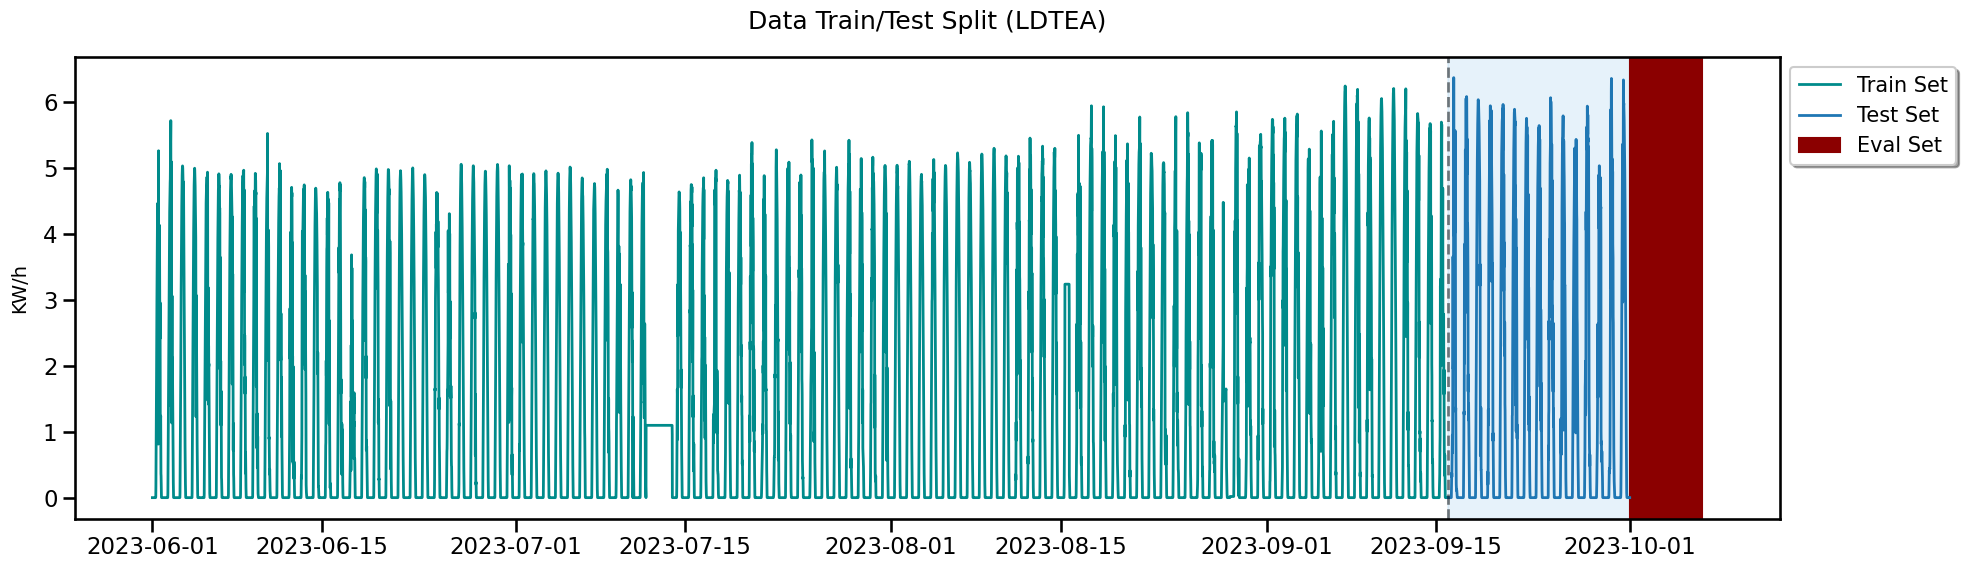

In [13]:
plt.figure(figsize=(22, 6))
plt.plot(df_train.index, df_train[TARGET], lw=2, color=color_train, label="Train Set")
plt.plot(df_test.index, df_test[TARGET], lw=2, color=color_test, label="Test Set")

plt.xlabel("")
plt.ylabel("KW/h", fontsize=14, labelpad=10)
plt.title("Data Train/Test Split (LDTEA)", fontsize=18, pad=20)

plt.axvline(SPLIT_DATE, color="black", lw=2, linestyle="--", alpha=0.5)
plt.axvspan(df_test.index.min(), df_test.index.max(), color=light_blue, alpha=0.3)
plt.axvspan(df_eval.index.min(), df_eval.index.max(), alpha=1, color=dark_red, label="Eval Set")

plt.legend(
    fontsize=15,
    frameon=True,
    shadow=True,
    framealpha=1,
    facecolor="white",
    bbox_to_anchor=(1, 1),
)
plt.show()


In [14]:
# Preparar serie temporal para previsão (treino e teste)
# X = features (hour_min)
# y = target (ldtea)

X_train = df_train[[FEATURES]]
y_train = df_train[[TARGET]]

X_test = df_test[[FEATURES]]
y_test = df_test[[TARGET]]

display(X_train.head(3), y_train.head(3))


hour_min
date_time                    
2023-06-01 00:00:00      0.00
2023-06-01 00:15:00      0.25
2023-06-01 00:30:00      0.50

ldtea
date_time                 
2023-06-01 00:00:00    0.0
2023-06-01 00:15:00    0.0
2023-06-01 00:30:00    0.0

In [28]:
# Definir modelo XGBoost base (parametros default) e treinar

xgb_base = xgb.XGBRegressor()

xgb_base.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=100,
)

# Prever os dados de teste com o modelo base e tunning
df_pred = df_test.rename(columns={TARGET: "test"}).copy()
df_pred["xgb_pred"] = xgb_base.predict(X_test)

# Avaliar as previsões com as métricas de erro
print_forecast_accuracy(df_pred["test"], df_pred["xgb_pred"], "XGBoot Base")


[0]	validation_0-rmse:1.44450	validation_1-rmse:1.73611
[99]	validation_0-rmse:0.56233	validation_1-rmse:0.72002

                           Resumo das métricas de precisão (forecast accuracy - XGBoot Base)                            

MAE  :     0.43 - As previsões, em média, estão 0.43 unidades distantes dos valores reais.
RMSE :     0.72 - O erro médio do seu modelo é de 0.72 unidades em relação aos valores observados.
R²   :     0.88 - O coeficiente de determinação R² é 0.88.
MSE  :     0.52 - A média dos quadrados das diferenças entre os valores previstos e reais é 0.52
MAPE :   67.06% - As previsões, em média, estão desviando em 67.06% dos valores reais.
sMAPE:  120.35% - indica um desvio médio de 120.35% das previsões em relação aos valores reais.



-----
#### LGBM Regressor

In [29]:
lgb_model = lgb.LGBMRegressor()

lgb_model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test), (X_test, y_test)],
)

df_pred["lgb_pred"] = lgb_model.predict(X_test)
print_forecast_accuracy(df_pred["test"], df_pred["lgb_pred"], "LightGBM")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 96
[LightGBM] [Info] Number of data points in the train set: 10272, number of used features: 1
[LightGBM] [Info] Start training from score 1.303806

                             Resumo das métricas de precisão (forecast accuracy - LightGBM)                             

MAE  :     0.43 - As previsões, em média, estão 0.43 unidades distantes dos valores reais.
RMSE :     0.72 - O erro médio do seu modelo é de 0.72 unidades em relação aos valores observados.
R²   :     0.88 - O coeficiente de determinação R² é 0.88.
MSE  :     0.52 - A média dos quadrados das diferenças entre os valores previstos e reais é 0.52
MAPE :   67.06% - As previsões, em média, estão desviando em 67.06% dos valores reais.
sMAPE:  120.34% - indica um desvio médio de 120.34% das previsões em relação aos valores reais.



--------
#### LinearRegression

In [30]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
score = lr_model.score(X_test, y_test)

df_pred["lr_pred"] = lr_model.predict(X_test)
print_forecast_accuracy(df_pred["test"], df_pred["lr_pred"], "Liner Regression")



                         Resumo das métricas de precisão (forecast accuracy - Liner Regression)                         

MAE  :     1.71 - As previsões, em média, estão 1.71 unidades distantes dos valores reais.
RMSE :     2.05 - O erro médio do seu modelo é de 2.05 unidades em relação aos valores observados.
R²   :    -0.01 - O coeficiente de determinação R² é -0.01.
MSE  :     4.22 - A média dos quadrados das diferenças entre os valores previstos e reais é 4.22
MAPE : 1257.52% - As previsões, em média, estão desviando em 1257.52% dos valores reais.
sMAPE:  146.29% - indica um desvio médio de 146.29% das previsões em relação aos valores reais.



--------
#### Random Forest Regressor

In [31]:
rfr_model = RandomForestRegressor()
rfr_model.fit(X_train, y_train)

df_pred["rfr_pred"] = rfr_model.predict(X_test)
print_forecast_accuracy(df_pred["test"], df_pred["rfr_pred"], "Random Forest Regressor")


/tmp/ipykernel_147607/4159693684.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfr_model.fit(X_train, y_train)



                     Resumo das métricas de precisão (forecast accuracy - Random Forest Regressor)                      

MAE  :     0.43 - As previsões, em média, estão 0.43 unidades distantes dos valores reais.
RMSE :     0.72 - O erro médio do seu modelo é de 0.72 unidades em relação aos valores observados.
R²   :     0.88 - O coeficiente de determinação R² é 0.88.
MSE  :     0.52 - A média dos quadrados das diferenças entre os valores previstos e reais é 0.52
MAPE :   67.81% - As previsões, em média, estão desviando em 67.81% dos valores reais.
sMAPE:  120.38% - indica um desvio médio de 120.38% das previsões em relação aos valores reais.



---
#### Decision Tree Regressor

In [32]:
dtr_model = DecisionTreeRegressor()
dtr_model.fit(X_train, y_train)

df_pred["dtr_pred"] = dtr_model.predict(X_test)
print_forecast_accuracy(df_pred["test"], df_pred["dtr_pred"], "Decision Tree Regressor")



                     Resumo das métricas de precisão (forecast accuracy - Decision Tree Regressor)                      

MAE  :     0.43 - As previsões, em média, estão 0.43 unidades distantes dos valores reais.
RMSE :     0.72 - O erro médio do seu modelo é de 0.72 unidades em relação aos valores observados.
R²   :     0.88 - O coeficiente de determinação R² é 0.88.
MSE  :     0.52 - A média dos quadrados das diferenças entre os valores previstos e reais é 0.52
MAPE :   67.02% - As previsões, em média, estão desviando em 67.02% dos valores reais.
sMAPE:  120.34% - indica um desvio médio de 120.34% das previsões em relação aos valores reais.



In [34]:
df_pred["test_avg"] = df_pred.groupby("hour_min")["test"].transform("mean")
df_pred.head()


test  hour_min  xgb_pred  lgb_pred   lr_pred  rfr_pred  \
date_time                                                                     
2023-09-16 00:00:00   0.0      0.00   0.02069  0.020714  1.257202  0.021268   
2023-09-16 00:15:00   0.0      0.25   0.02069  0.020714  1.258183  0.018701   
2023-09-16 00:30:00   0.0      0.50   0.02069  0.020714  1.259164  0.018424   
2023-09-16 00:45:00   0.0      0.75   0.02069  0.020714  1.260145  0.019406   
2023-09-16 01:00:00   0.0      1.00   0.02069  0.020714  1.261126  0.022826   

                     dtr_pred  y_true_mean  
date_time                                   
2023-09-16 00:00:00  0.020678     0.000000  
2023-09-16 00:15:00  0.020678     0.000000  
2023-09-16 00:30:00  0.020678     0.000000  
2023-09-16 00:45:00  0.020678     0.000167  
2023-09-16 01:00:00  0.020678     0.000000

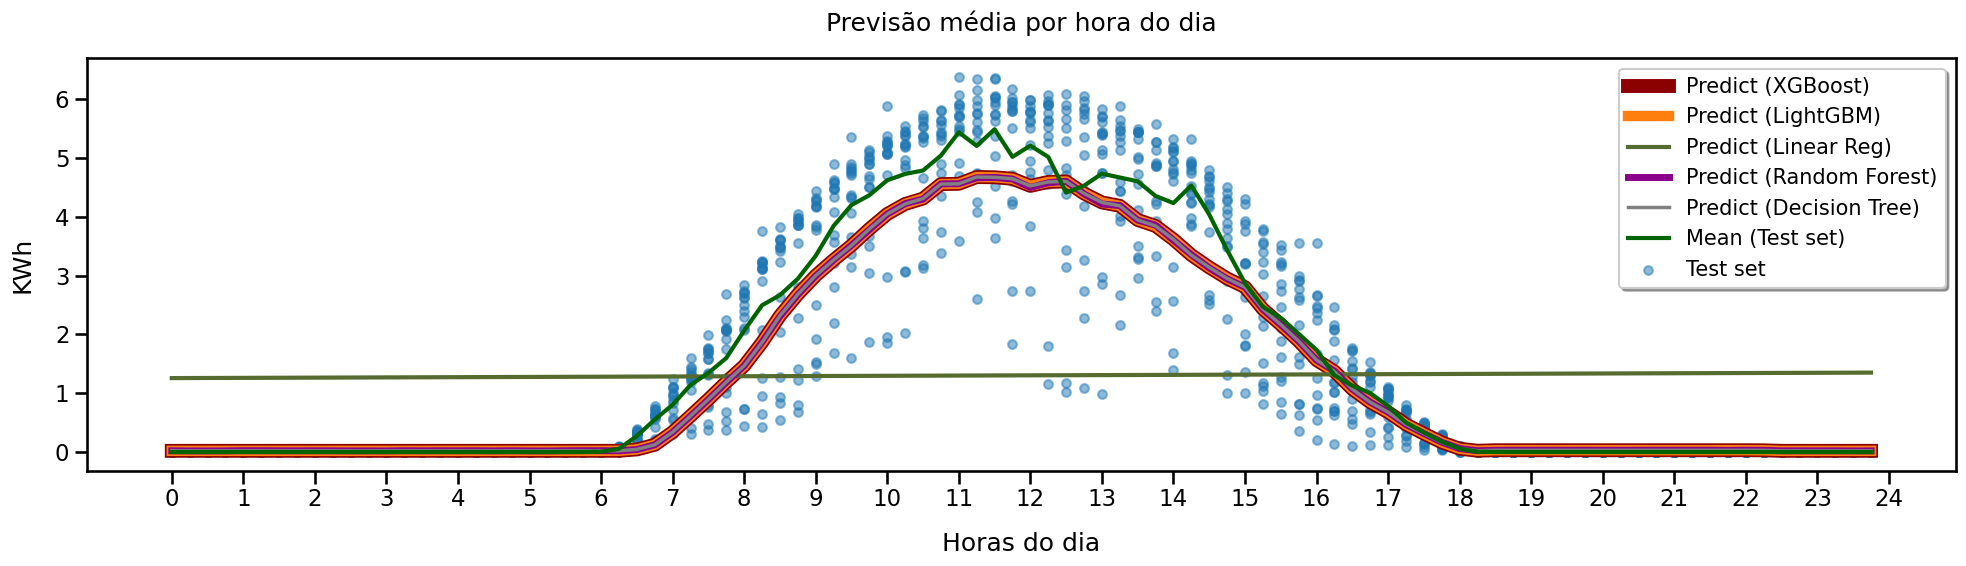

In [38]:
mean_pred = df_pred.groupby("hour_min").mean()

plt.figure(figsize=(20, 6))

predictions = [
    ("Predict (XGBoost)", "xgb_pred", dark_red, 10),
    ("Predict (LightGBM)", "lgb_pred", color_future, 7.5),
    ("Predict (Linear Reg)", "lr_pred", dark_olive, 3),
    ("Predict (Random Forest)", "rfr_pred", dark_magenta, 5),
    ("Predict (Decision Tree)", "dtr_pred", "gray", 2.5),
    ("Mean (Test set)", "test", dark_green, 3),
]

for label, pred_col, color, linewidth in predictions:
    plt.plot(
        mean_pred.index,
        mean_pred[pred_col],
        label=label,
        color=color,
        linewidth=linewidth,
    )

plt.scatter(
    df_pred["hour_min"],
    df_pred["test"],
    label="Test set",
    color=color_test,
    s=40,
    alpha=0.5,
)

plt.xticks(np.arange(0, 25))
plt.title("Previsão média por hora do dia", fontsize=18, pad=20)
plt.xlabel("Horas do dia", labelpad=15)
plt.ylabel("KWh", labelpad=15)
plt.legend(
    fontsize=15,
    frameon=True,
    shadow=True,
    framealpha=1,
    facecolor="white",
)
plt.tight_layout()
plt.show()


------


In [54]:
df_score = pd.DataFrame()

df_score["XGBoost"] = calculate_forecast_accuracy(df_pred["test"], df_pred["xgb_pred"])
df_score["LightGBM"] = calculate_forecast_accuracy(df_pred["test"], df_pred["lgb_pred"])
df_score["Linear Regression"] = calculate_forecast_accuracy(df_pred["test"], df_pred["lr_pred"])
df_score["Random Forest"] = calculate_forecast_accuracy(df_pred["test"], df_pred["rfr_pred"])
df_score["Decision Tree"] = calculate_forecast_accuracy(df_pred["test"], df_pred["dtr_pred"])

df_score = df_score.T
df_score = df_score.round(2)
df_score.sort_values(by=["mae", "mse", "rmse"], inplace=True)
# df_score = df_score[["mae", "mse", "rmse", "r2", "mape", "smape"]]
df_score = df_score.iloc[:-1]
df_score.head()


mae   mse  rmse    r2   mape   smape
XGBoost        0.43  0.52  0.72  0.88  67.06  120.35
LightGBM       0.43  0.52  0.72  0.88  67.06  120.34
Random Forest  0.43  0.52  0.72  0.88  67.81  120.38
Decision Tree  0.43  0.52  0.72  0.88  67.02  120.34

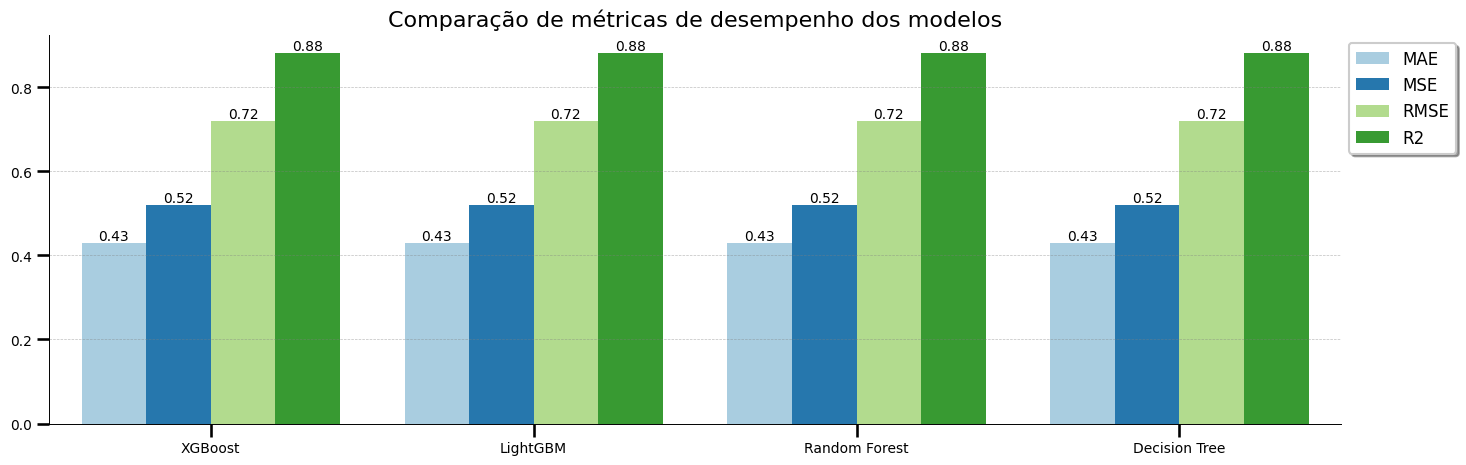

In [71]:

df_plot = (
    df_score[["mae", "mse", "rmse", "r2"]]
    .reset_index()
    .melt(
        id_vars="index",
        var_name="metric",
        value_name="value",
    )
)
df_plot["metric"] = df_plot["metric"].str.upper()

fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(
    data=df_plot,
    x="index",
    y="value",
    hue="metric",
    width=0.8,
    palette="Paired",
    saturation=0.9,
    dodge=True, 
)

ax.set_title("Comparação de métricas de desempenho dos modelos", fontsize=16)
ax.set_xlabel("")
ax.set_ylabel("")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_linewidth(0.7)
ax.spines["bottom"].set_linewidth(0.7)
ax.yaxis.grid(True, linestyle="--", linewidth=0.5, color="gray", alpha=0.5)

plt.xticks(rotation=0, ha="center", fontsize=10)
plt.yticks(fontsize=10)

for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.2f}",
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="bottom",
        fontsize=10,
        color="black",
    )

plt.legend(
    loc="upper left",
    fontsize=12,
    frameon=True,
    shadow=True,
    framealpha=1,
    facecolor="white",
    bbox_to_anchor=(1, 1),
)
plt.tight_layout()
plt.show()


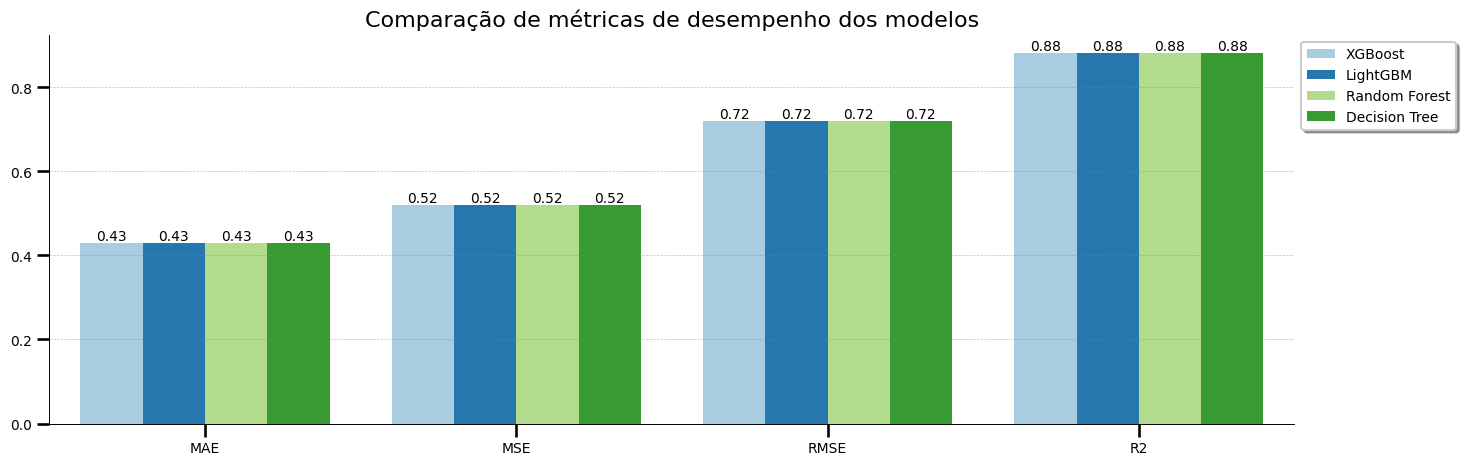

In [74]:
df_plot = (
    df_score[["mae", "mse", "rmse", "r2"]]
    .reset_index()
    .melt(
        id_vars="index",
        var_name="metric",
        value_name="value",
    )
)
df_plot["metric"] = df_plot["metric"].str.upper()

fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(
    data=df_plot,
    x="metric",
    y="value",
    hue="index",
    width=0.8,
    palette="Paired",
    saturation=0.9,
    dodge=True, 
)

ax.set_title("Comparação de métricas de desempenho dos modelos", fontsize=16)
ax.set_xlabel("")
ax.set_ylabel("")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_linewidth(0.7)
ax.spines["bottom"].set_linewidth(0.7)
ax.yaxis.grid(True, linestyle="--", linewidth=0.5, color="gray", alpha=0.5)

plt.xticks(rotation=0, ha="center", fontsize=10)
plt.yticks(fontsize=10)

for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.2f}",
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="bottom",
        fontsize=10,
        color="black",
    )

plt.legend(
    loc="upper left",
    fontsize=10,
    frameon=True,
    shadow=True,
    framealpha=1,
    facecolor="white",
    bbox_to_anchor=(1, 1),
)
plt.tight_layout()
plt.show()


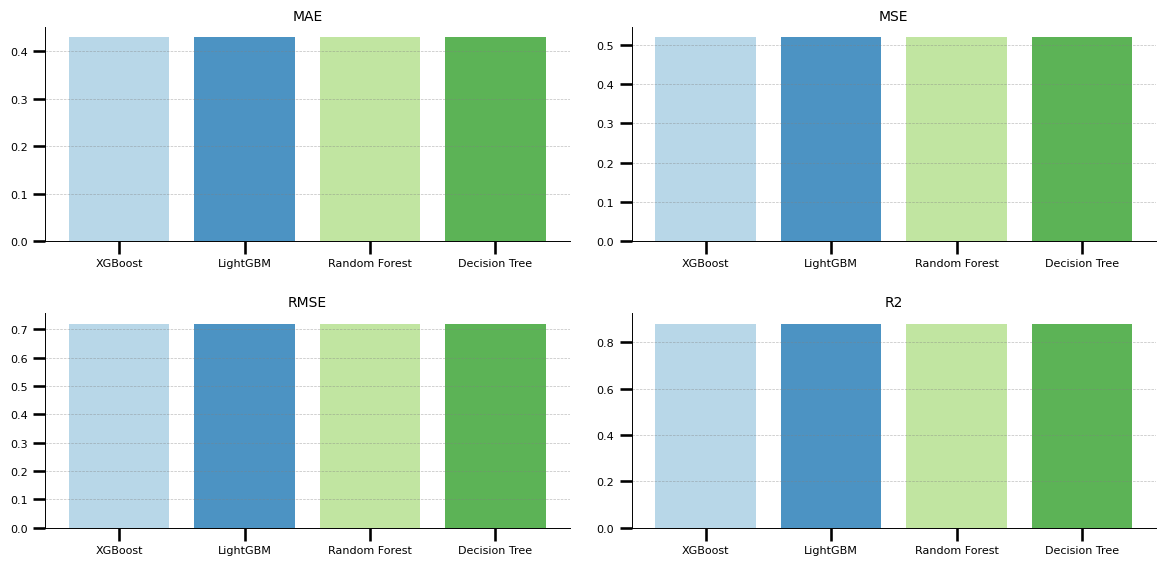

In [86]:
df_plot = (
    df_score[["mae", "mse", "rmse", "r2"]]
    .reset_index()
    .melt(
        id_vars="index",
        var_name="metric",
        value_name="value",
    )
)

colors = sns.color_palette("Paired")

fig, axes = plt.subplots(2, 2, figsize=(12, 6))

metrics = df_plot["metric"].unique()
for i, j in itertools.product(range(2), range(2)):
    metric = metrics[i * 2 + j]
    ax = axes[i, j]
    df_group = df_plot[df_plot["metric"] == metric].copy()
    df_group.sort_values("value", ascending=True, inplace=True)

    ax.bar(
        df_group["index"],
        df_group["value"],
        color=colors,
        alpha=0.8,
    )

    ax.set_title(f"{metric.upper()}", fontsize=10, pad=5)
    ax.tick_params(axis="x", labelsize=8)
    ax.tick_params(axis="y", labelsize=8)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_linewidth(0.7)
    ax.spines["bottom"].set_linewidth(0.7)
    ax.yaxis.grid(True, linestyle="--", linewidth=0.5, color="gray", alpha=0.5)

plt.tight_layout()
plt.show()


In [82]:
df_plot = pd.concat([df_train[TARGET], df_pred], axis=1)
df_plot.rename(columns={TARGET: "train"}, inplace=True)
df_plot


train  test  hour_min  xgb_pred  lgb_pred   lr_pred  \
date_time                                                                  
2023-06-01 00:00:00    0.0   NaN       NaN       NaN       NaN       NaN   
2023-06-01 00:15:00    0.0   NaN       NaN       NaN       NaN       NaN   
2023-06-01 00:30:00    0.0   NaN       NaN       NaN       NaN       NaN   
2023-06-01 00:45:00    0.0   NaN       NaN       NaN       NaN       NaN   
2023-06-01 01:00:00    0.0   NaN       NaN       NaN       NaN       NaN   
...                    ...   ...       ...       ...       ...       ...   
2023-09-30 22:45:00    NaN   0.0     22.75  0.020561  0.020556  1.346487   
2023-09-30 23:00:00    NaN   0.0     23.00  0.020561  0.020556  1.347468   
2023-09-30 23:15:00    NaN   0.0     23.25  0.020561  0.020556  1.348449   
2023-09-30 23:30:00    NaN   0.0     23.50  0.020561  0.020556  1.349430   
2023-09-30 23:45:00    NaN   0.0     23.75  0.020643  0.020705  1.350411   

                     rfr_pred  dtr_pred  y_true_mean  
date_time                                             
2023-06-01 00:00:00       NaN       NaN          NaN  
2023-06-01 00:15:00       NaN       NaN          NaN  
2023-06-01 00:30:00       NaN       NaN          NaN  
2023-06-01 00:45:00       NaN       NaN          NaN  
2023-06-01 01:00:00       NaN       NaN          NaN  
...                       ...       ...          ...  
2023-09-30 22:45:00  0.020930  0.020514          0.0  
2023-09-30 23:00:00  0.020679  0.020514          0.0  
2023-09-30 23:15:00  0.020359  0.020514          0.0  
2023-09-30 23:30:00  0.018525  0.020514          0.0  
2023-09-30 23:45:00  0.019746  0.020678          0.0  

[11712 rows x 9 columns]

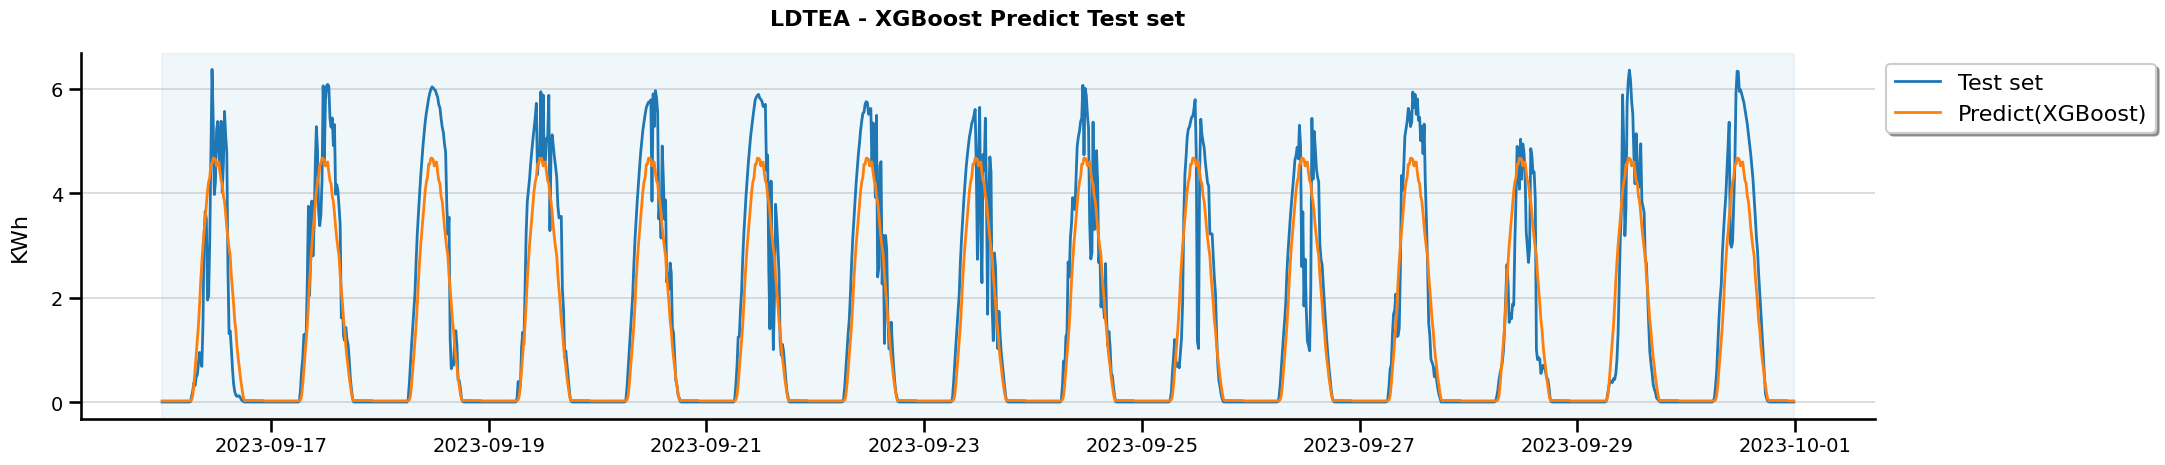

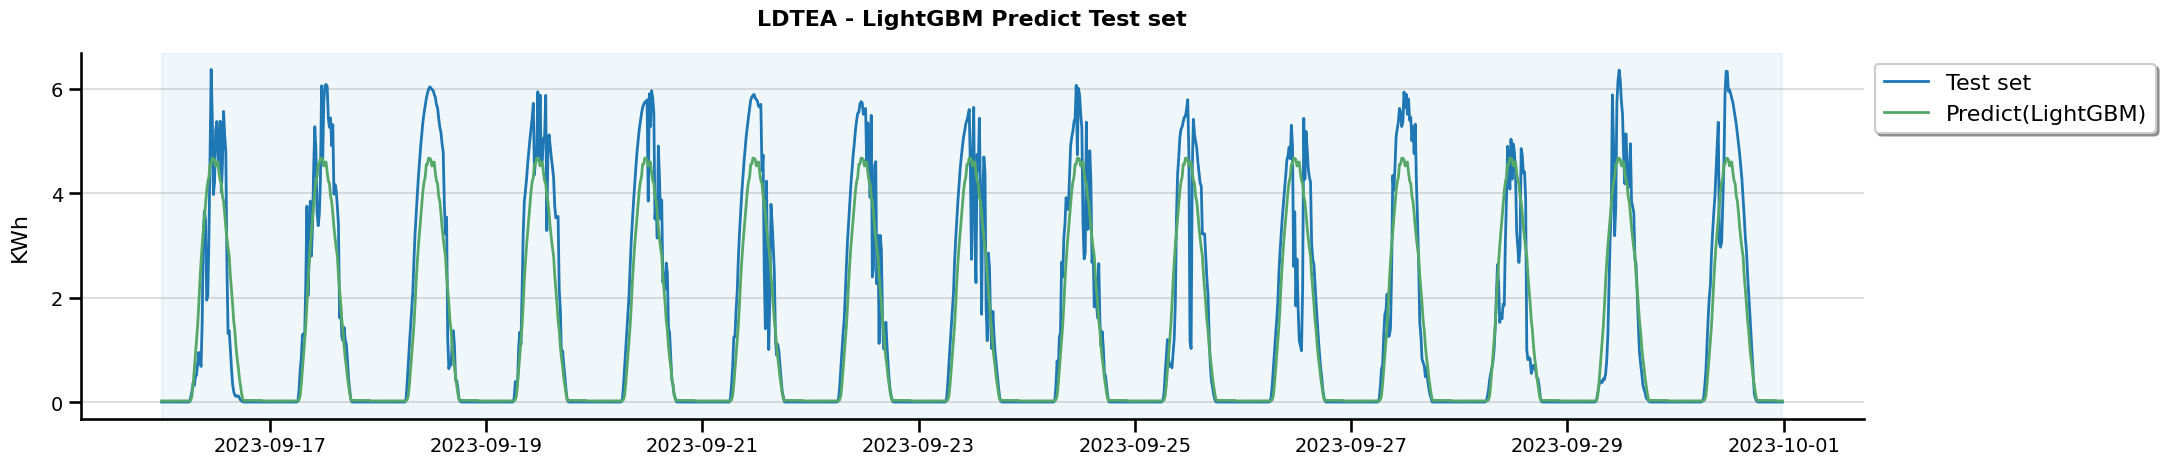

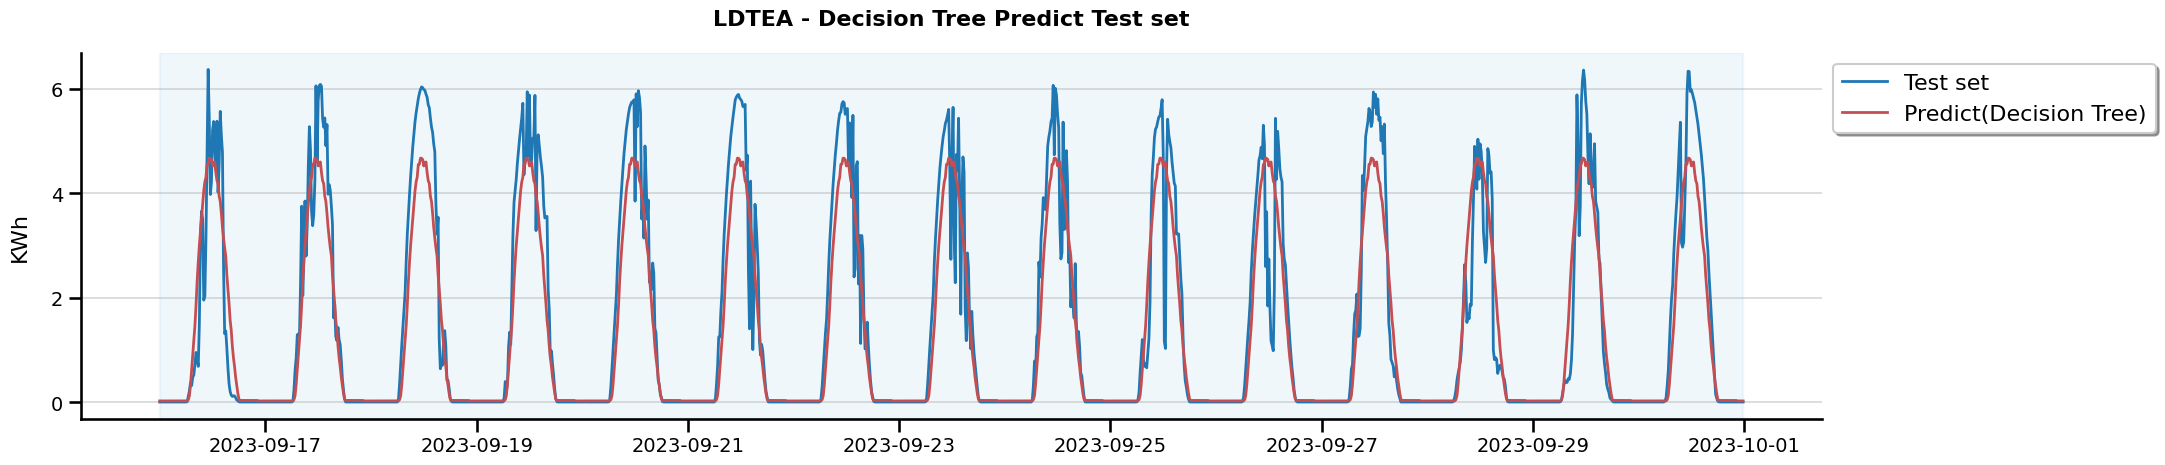

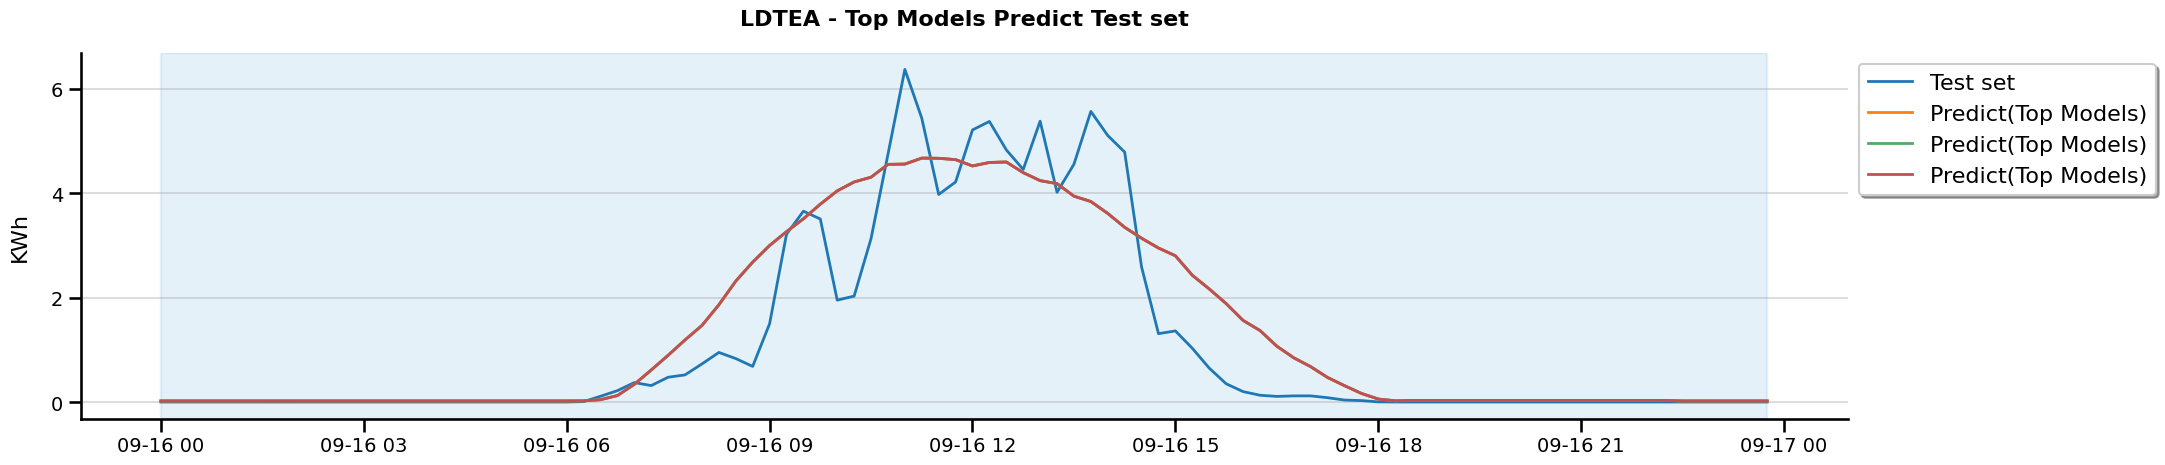

In [91]:
# Plotar previsao de energia (LDTEA) no conjunto de teste

df_plot = pd.concat([df_train[TARGET], df_pred], axis=1)
df_plot.rename(columns={TARGET: "train"}, inplace=True)

plot_forecast(df_plot[["test", "xgb_pred"]], "XGBoost", span=True)
plot_forecast(df_plot[["test", "lgb_pred"]], "LightGBM", span=True)
plot_forecast(df_plot[["test", "dtr_pred"]], "Decision Tree", span=True)

start = df_train.index.max() - pd.DateOffset(days=0)
end = start + pd.DateOffset(days=1)
plot_forecast(
    df_plot[["test", "xgb_pred", "lgb_pred", "dtr_pred"]],
    "Top Models",
    start,
    end,
    span=True,
)


----
#### Detectar anomalias 

In [93]:
# Criar um DataFrame df_result com os dados de teste, previsões e métricas de erro do modelo LightGBM

df_result_lgb = pd.concat([X_test["hour_min"], df_pred[["test", "lgb_pred"]]], axis=1)
df_result_lgb["error"] = df_result_lgb["lgb_pred"] - df_result_lgb["y_true"]
df_result_lgb["mae"] = df_result_lgb["error"].abs()
df_result_lgb.head(3)


KeyError: 'y_true'

In [ ]:
std_error = df_result_lgb["error"].std()
mean_error = df_result_lgb["error"].mean()

# detectar anomalias usando Z-Score
df_result_lgb["anomaly_z_score"] = (df_result_lgb["error"] - mean_error) / std_error
df_result_lgb["anomaly_z_score"] = (df_result_lgb["anomaly_z_score"].abs() > 2).astype(int)

# detectar anomalias usando IsolationForest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
df_result_lgb["anomaly_isoforest"] = iso_forest.fit_predict(df_result_lgb[["error"]])
df_result_lgb["anomaly_isoforest"] = np.where(df_result_lgb["anomaly_isoforest"] == -1, 1, 0).astype(int)

print("Anomalias detectadas usando:")
print(f"Z-Score: {df_result_lgb['anomaly_z_score'].sum()}")
print(f"Isolation Forest: {df_result_lgb['anomaly_isoforest'].sum()}")


In [ ]:
mean_pred = df_result_lgb.groupby("hour_min")[["lgb_pred"]].mean()

plt.figure(figsize=(20, 6))

plt.scatter(
    df_result_lgb["hour_min"],
    df_result_lgb["y_true"],
    label="Valores Reais",
    color=color_test,
    s=50,
    zorder=5,
    alpha=0.5,
)
plt.plot(
    mean_pred.index,
    mean_pred["lgb_pred"],
    label="Previsões",
    color="#fca311",
    linewidth=4,
    zorder=10,
)

anomalies = df_result_lgb[df_result_lgb["anomaly_isoforest"] == 1]
plt.scatter(
    anomalies["hour_min"],
    anomalies["y_true"],
    color="red",
    s=50,
    zorder=5,
    label="Anomalias (Isolation Forest)",
)

plt.title("Detector de Anomalias usando Isolation Forest", fontsize=20, pad=20)
plt.xlabel("Hora do Dia", fontsize=13, labelpad=15)
plt.ylabel("KWh", fontsize=13, labelpad=15)
plt.grid(True, linestyle="--", alpha=0.5, lw=0.6)
plt.xticks(np.arange(0, 25))
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.legend(
    fontsize=15,
    frameon=True,
    shadow=True,
    framealpha=1,
    facecolor="white",
)
plt.tight_layout()
plt.show()


In [ ]:
mean_pred = df_result_lgb.groupby("hour_min")[["lgb_pred"]].mean()

plt.figure(figsize=(20, 6))

plt.scatter(
    df_result_lgb["hour_min"],
    df_result_lgb["y_true"],
    label="Valores Reais",
    color=color_test,
    s=50,
    zorder=5,
    alpha=0.5,
)
plt.plot(
    mean_pred.index,
    mean_pred["lgb_pred"],
    label="Previsões",
    color="#fca311",
    linewidth=4,
    zorder=10,
)

anomalies = df_result_lgb[df_result_lgb["anomaly_z_score"] == 1]
plt.scatter(
    anomalies["hour_min"],
    anomalies["y_true"],
    color="red",
    s=50,
    zorder=5,
    label="Anomalies (z_score)",
)

plt.title("Detector de anomalias usando z_score", fontsize=20, pad=20)
plt.xlabel("Hora do Dia", fontsize=13, labelpad=15)
plt.ylabel("KWh", fontsize=13, labelpad=15)
plt.grid(True, linestyle="--", alpha=0.5, lw=0.6)
plt.xticks(np.arange(0, 25))
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.legend(
    fontsize=15,
    frameon=True,
    shadow=True,
    framealpha=1,
    facecolor="white",
)
plt.tight_layout()
plt.show()


O gráfico apresenta os dados de teste e as predições em função das horas do dia.

Isso permite visualizar como o modelo se comporta em diferentes horas do dia e identificar 
se há padrões específicos ou períodos de tempo em que o modelo tende a ter um desempenho melhor ou pior

In [ ]:
mae_by_hour = df_result_lgb.groupby("hour_min")["mae"].mean()

plt.figure(figsize=(20, 6))
mae_by_hour.plot(
    color=dark_cyan,
    marker="o",
    ls="-",
    label="Mean Error",
    alpha=0.8,
    lw=3,
    markersize=8,
    markerfacecolor=dark_blue,
)

plt.title("Mean Absolute Error (MAE) por hora do dia", fontsize=18, pad=20)
plt.xlabel("Hora do dia (0-24)", fontsize=13, labelpad=15)
plt.ylabel("Erro Medio", fontsize=13, labelpad=15)

plt.xticks(np.arange(0, 25))
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle="--", alpha=0.5, lw=0.7)
plt.tight_layout()
plt.show()


In [ ]:
# Esta é uma abordagem simplificada para detecção de anomalias. Existem muitos outros métodos mais sofisticados e 
# técnicas específicas para séries temporais, mas este método baseado em resíduos é intuitivo e muitas vezes eficaz 
# para identificar pontos que se desviam significativamente das previsões.


-------
#### Curva de carga

In [ ]:
array = np.arange(0, 24, 0.25)
X_future = pd.DataFrame(array, columns=["hour_min"])

predict_curve = lgb_model.predict(X_future)
predict_curve = pd.DataFrame(predict_curve, index=array ,columns=["lgb_pred"])
display(predict_curve)


In [ ]:
mean_test = df_test.groupby("hour_min")[TARGET].mean()
median_test = df_test.groupby("hour_min")[TARGET].median()

plt.figure(figsize=(22, 6))

plt.scatter(
    X_test["hour_min"],
    y_test["ldtea"],
    label="Test set",
    color=color_test,
    s=40,
    alpha=0.4,
)

plt.plot(
    predict_curve.index,
    predict_curve["lgb_pred"],
    color=dark_orange,
    label="Predict (LightGBM)",
    linewidth=4,
)

plt.plot(
    mean_test.index,
    mean_test,
    color=dark_red,
    label="Mean (Test set)",
    linewidth=4,
)
plt.plot(
    median_test.index,
    median_test,
    color=dark_olive,
    label="Median (Test set)",
    linewidth=4,
)

plt.title("Curva de Geração de Energia (LightGBM)", fontsize=16, pad=20)
plt.xlabel("Horas do Dia", fontsize=12, labelpad=10)
plt.ylabel("KWh", fontsize=12, labelpad=10)
plt.xticks(range(0, 25))
plt.legend(fontsize=15, loc="upper right")
plt.grid(True, linestyle="--", alpha=0.5, lw=0.5)
plt.show()
